# HDSC: exploratory data analysis

Import all the libraries needed for the exploratory data analysis phase.

In [75]:
import os
import numpy as np
import xarray as xr
import warnings
import torchhd
import torch
import torch.nn.functional as F
from urllib3.exceptions import NotOpenSSLWarning
import matplotlib.pyplot as plt

Configure the runtime environment settings.

In [76]:
# I/O configuration
input_folder = '../data/ncdf'
output_folder = '../data/ncdf'

# Runtime configuration
os.makedirs(output_folder, exist_ok=True)

# Ignore annoying urllib3 warnings
warnings.filterwarnings("ignore", category=NotOpenSSLWarning)

# Load dataset
dataset = xr.load_dataarray(os.path.join(input_folder, "nrm.orx.dataset.nc"))

In the context of HDC/VSA, all symbolic data structure are build upon compositions of fixed-size hypervectors. These hypervectors must satisfy two fundamental criteria:
1. they should be of relatively large dimensionality (common sizes range from 1000 to more than 10000 dimensions)
2. they should be pseudo-orthogonal (i.e. their cosine similarity/dot product must be approximately 0)

Whenever we randomly sample hypervectors from a high-dimensional space, these two conditions are automatically satisfied. In our case, we are starting from a set of highly-dimensional non-random signals. Randomness is not inherently needed, but it favourably yields pseudo-orthogonality, which is the second, non-negotiable criterium in HDC/VSA computations. As long as our signals are pseudo-orthogonal, we can fully exploit HDC/VSA powerful computational primitives. 

After the ETL phase, our dataset comprises a set of refined signals that we can use in two ways:
- "As-is" version: no modifications to original data is applied. This choice implies two consequences:
  - the hypervectors encoding of choice should be compatible to the format of our data (i.e. real numbers); this limits our encoding possibilities
  - the dimensionality of our hypervectors should be compatible with that of our refined signals; in this case, this is not really an issue, since we can increase the dimensionality of our signals by interpolative augmentation, as shown in the etl.ipynb notebook.
- "Hyperdimensionally-embedded" version. We apply a linear/non-linear projection to our signals, in order to gain the possibility to automatically embed in lower/higher dimensional space (no interpolations needed), as well as choosing the data format (i.e. hypervectors with boolean, real, or complex components).
  - A desired property for our embeddings is, of course, similarity-preservation with respect to the original signals.

In order to understand if our signals can be used in the "as-is" version, we have to make sure that they are non-similar (i.e. pseudo-orthogonal). It is important to remark that HDC/VSA is massively robust to noise, thus, with a bit of flexibility and informality, we can demote the "pseudo-orthogonality" property to "just enough non-similarity".

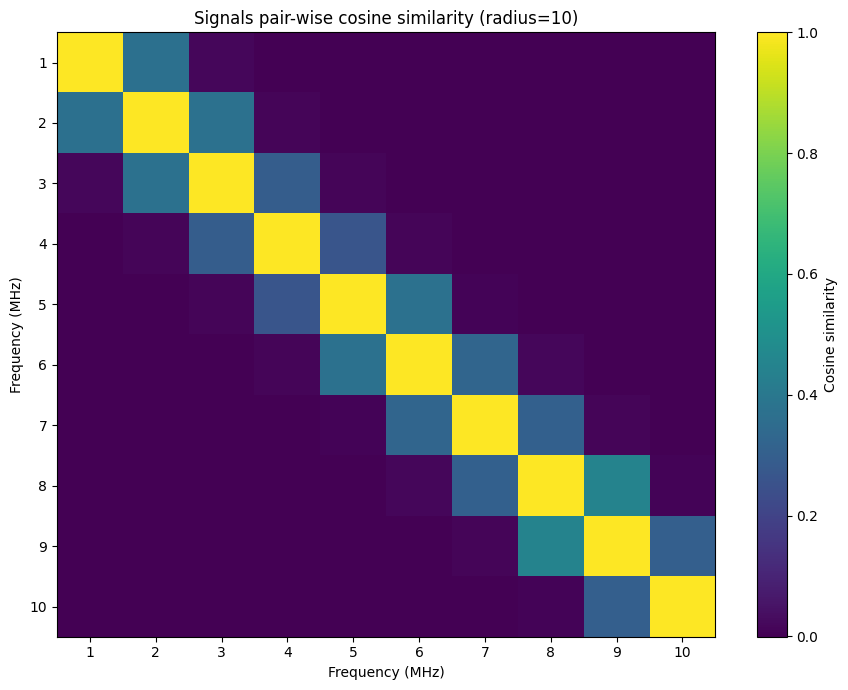

In [77]:
radius = 10
as_is_dataset = torchhd.HRRTensor(dataset.sel(radius=radius).values)

normed_as_is_dataset = torch.nn.functional.normalize(as_is_dataset, p=2, dim=1)
similarity_matrix = normed_as_is_dataset @ normed_as_is_dataset.T

# Convert to numpy for plotting
similarities_np = similarity_matrix.cpu().numpy()

plt.figure(figsize=(9, 7))
plt.imshow(similarities_np, cmap="viridis", aspect="auto")
plt.colorbar(label="Cosine similarity")
plt.title(f"Signals pair-wise cosine similarity (radius={radius})")
plt.xlabel("Frequency (MHz)")
plt.ylabel("Frequency (MHz)")
plt.xticks(ticks=range(len(dataset.frequency.values)), labels=dataset.frequency.values)
plt.yticks(ticks=range(len(dataset.frequency.values)), labels=dataset.frequency.values)

plt.tight_layout()
plt.show()




Having fixed radius=10, we can see that, in general, a random pair of signals at different central frequencies is pseudo-orthogonal. That said, for neighbouring frequencies (e.g.: {1MHz, 3Mhz} are the neighbouring frequency of signals at 2MHz), the similarity is slightly more visible; realistically speaking though, we are still in the "just enough non-similarity" zone, no need to worry here. We can now expand our visualization to all the radii sizes. Let's make a plot to verify whether or not what we have seen for radius=10 holds across all radii.

NOTE: the colorbar will not be printed in the plot below to avoid wasting screen space. The heatmap uses the same colorscheme as the plot present in the cell before.

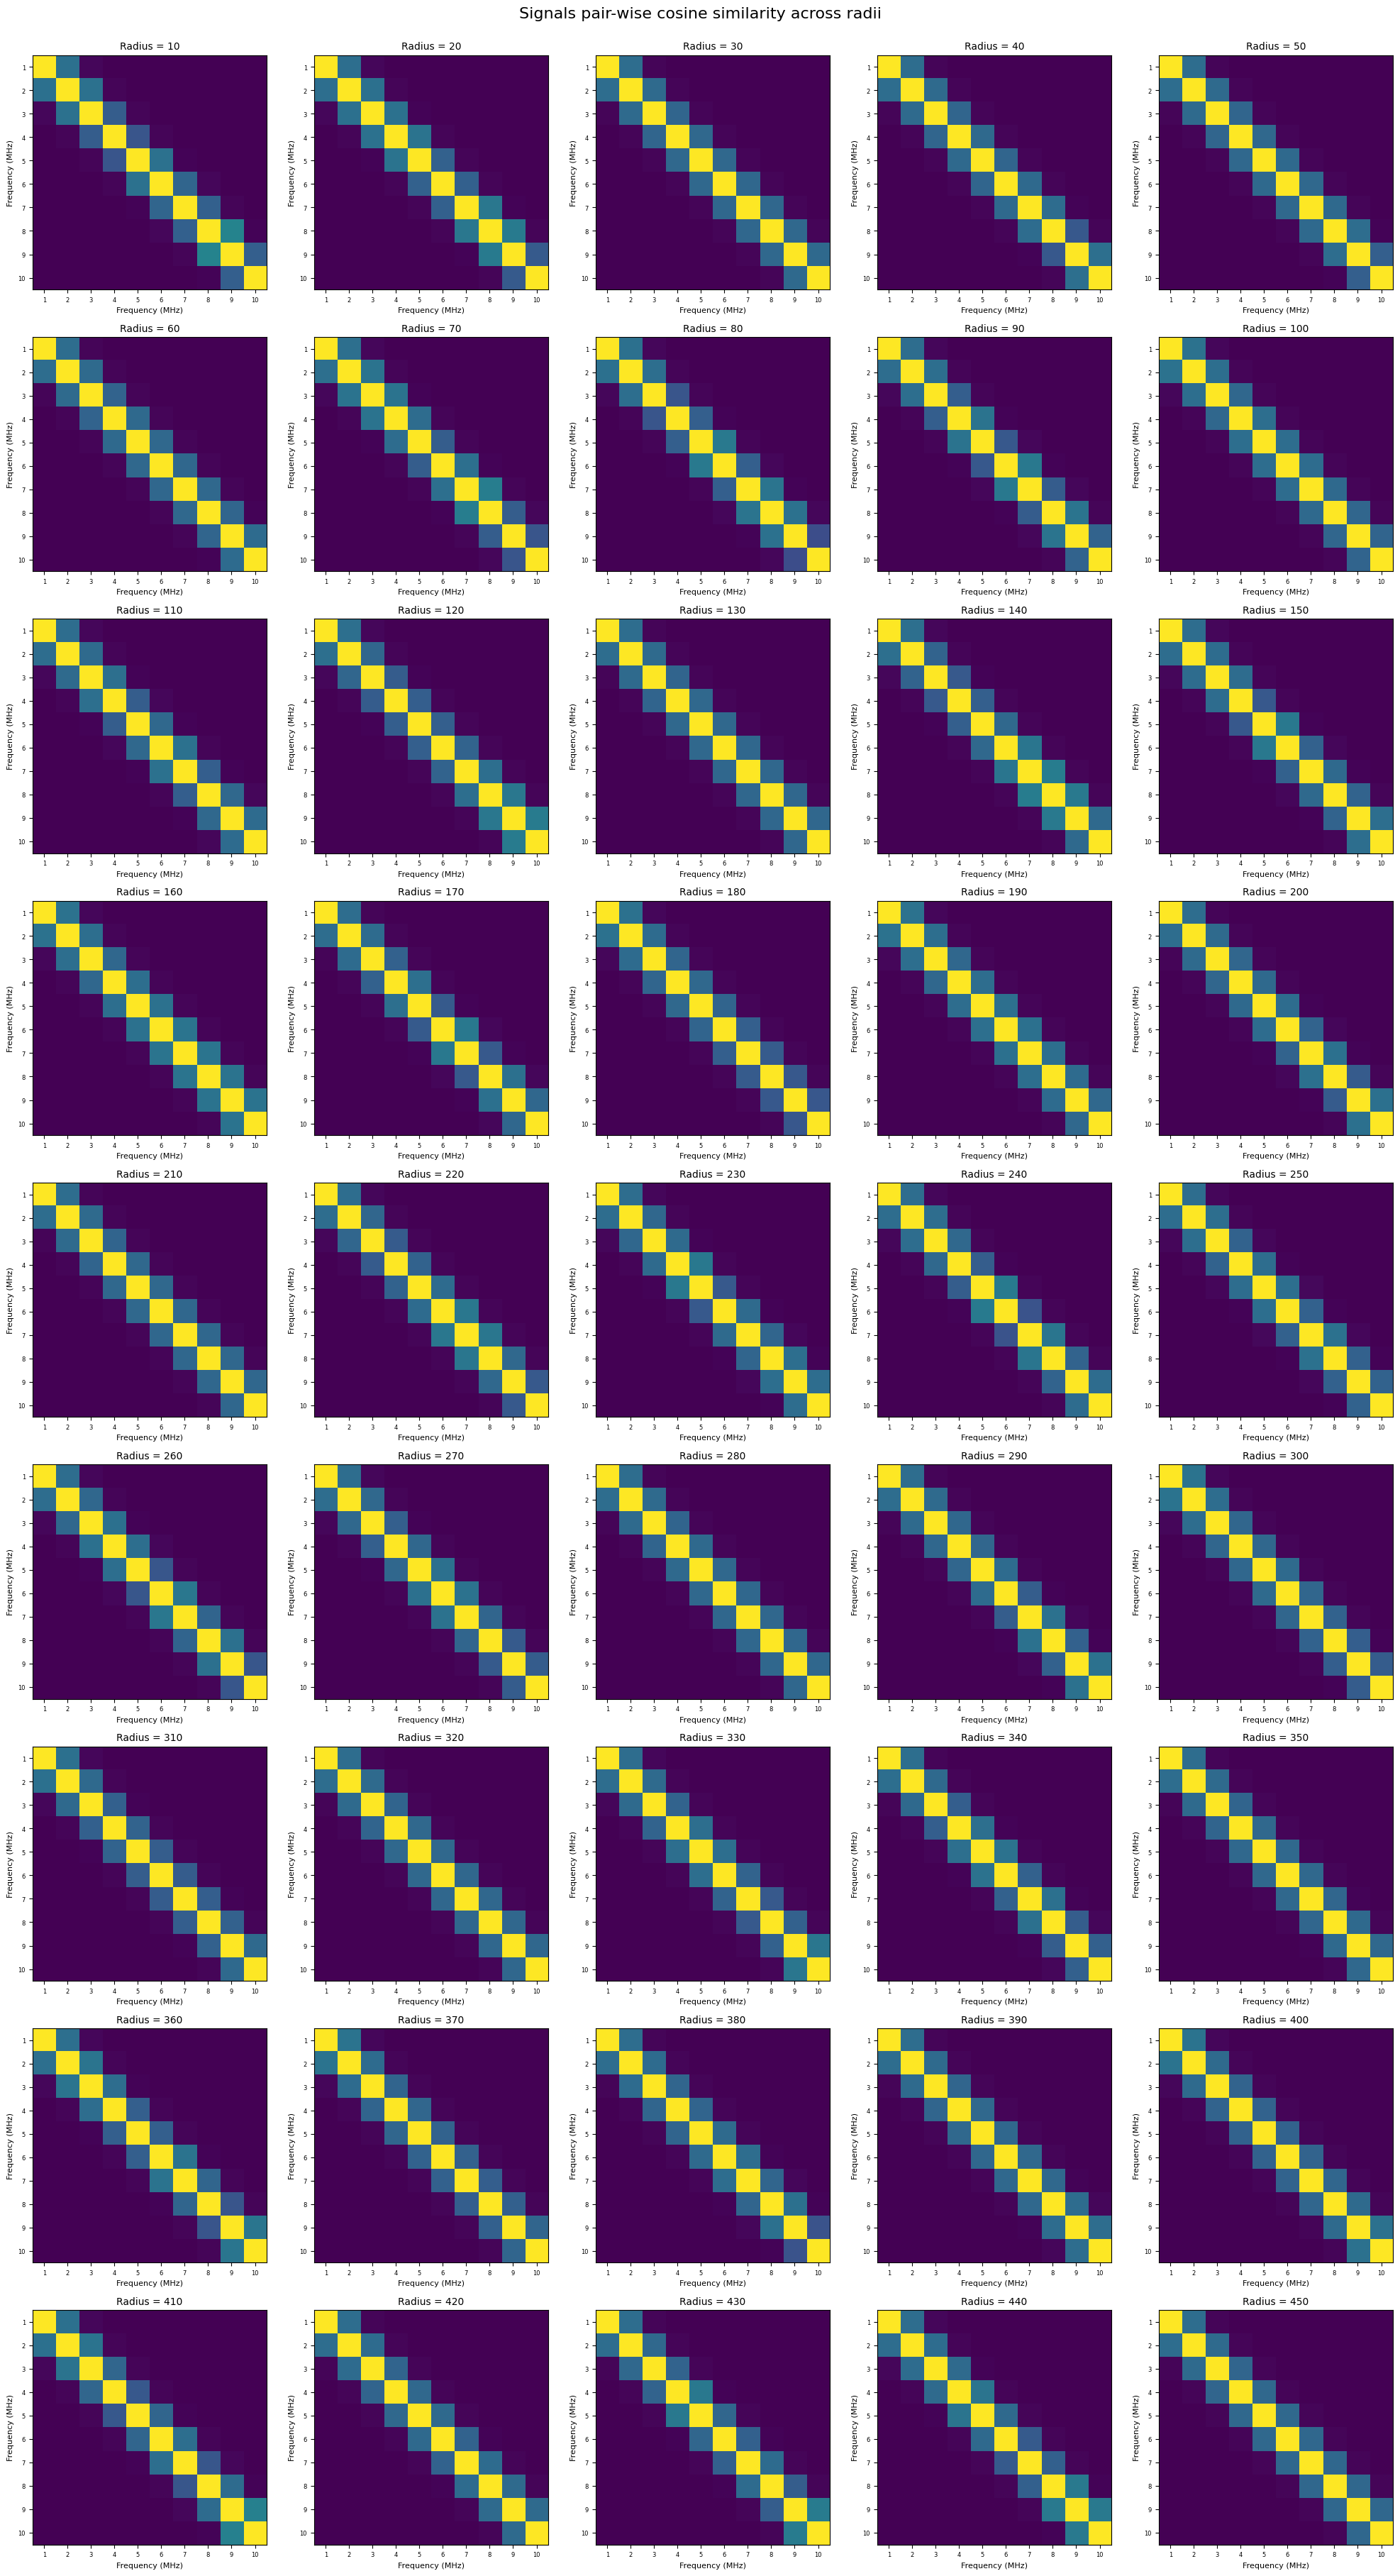

In [78]:
radii = dataset.radius.values  # 10, 20, ..., 450
n_rows, n_cols = 9, 5           # 9x5 grid = 45 subplots

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 37))

for i, radius in enumerate(radii):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col]

    # --- Compute similarity matrix ---
    as_is_dataset = torchhd.HRRTensor(dataset.sel(radius=radius).values)
    normed_as_is_dataset = F.normalize(as_is_dataset, p=2, dim=1)
    similarity_matrix = normed_as_is_dataset @ normed_as_is_dataset.T
    similarities_np = similarity_matrix.cpu().numpy()

    # --- Plot ---
    ax.imshow(similarities_np, cmap="viridis", aspect="auto")
    ax.set_aspect('equal')
    ax.set_title(f"Radius = {radius}", fontsize=10)
    ax.set_xlabel("Frequency (MHz)", fontsize=8)
    ax.set_ylabel("Frequency (MHz)", fontsize=8)
    ax.set_xticks(range(len(dataset.frequency.values)))
    ax.set_yticks(range(len(dataset.frequency.values)))
    ax.set_xticklabels(dataset.frequency.values, fontsize=6)
    ax.set_yticklabels(dataset.frequency.values, fontsize=6)

# --- Layout adjustments ---
fig.suptitle("Signals pair-wise cosine similarity across radii", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()


Good news: given a fixed radius size, different central frequencies lead to pseudo-orthogonal signals, independently from the radius dimension. This is theoretically expected, but must not be taken for granted in real-world scenarios.

Now, the interesting part: let's study how much similar our signals are fixing the central frequency and varying the radius. Let's define a **similarity_plot()** method, where we can parametrically define which kind of embedding of our data we want (embedding_type = {"none", "fractional", "sinusoid", "projection"}).

In [79]:
def similarity_plot(embedding_type="none"):    
    frequencies = dataset.frequency.values  # 1 .. 10
    n_rows, n_cols = 5, 2                   # 9x5 grid = 45 subplots
    n = 10000                               # Embeddings dimensionality

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 50))

    # These are some of the similarity-preserving embeddings available in torchhd; some are not capable to output an HRR vector (like the density embedding), so we do not use them here in order to not complicate the code.
    fractional = torchhd.embeddings.FractionalPower(dataset.time.size, n, vsa="HRR")
    projection = torchhd.embeddings.Projection(dataset.time.size, n, vsa="HRR")
    sinusoid = torchhd.embeddings.Sinusoid(dataset.time.size, n, vsa="HRR")
    # density = torchhd.embeddings.Density(dataset.time.size, n, vsa="FHRR")

    hdembed = {
        "fractional": fractional,
        "projection": projection,
        "sinusoid": sinusoid,
        # "density": density
    }
    
    embed = "none"
    if embedding_type != "none":
        embed = hdembed[embedding_type]

    for i, frequency in enumerate(frequencies):
        row = i // n_cols
        col = i % n_cols
        ax = axes[row, col]

        # --- Compute similarity matrix ---
        as_is_dataset = dataset.sel(frequency=frequency).values
        embedded_dataset = torchhd.HRRTensor(as_is_dataset)
        if embedding_type != "none":
            embedded_dataset = embed(torchhd.HRRTensor((as_is_dataset)))
        normed_embedded_dataset = F.normalize(embedded_dataset, p=2, dim=1)
        similarity_matrix = normed_embedded_dataset @ normed_embedded_dataset.T
        similarities_np = similarity_matrix.cpu().numpy()

        # --- Plot ---
        ax.imshow(similarities_np, cmap="viridis", aspect="auto")
        ax.set_aspect('equal')
        ax.set_title(f"Frequency = {frequency}MHz", fontsize=10)
        ax.set_xlabel("Radius", fontsize=8)
        ax.set_ylabel("Radius", fontsize=8)
        ax.set_xticks(range(len(dataset.radius.values)))
        ax.set_yticks(range(len(dataset.radius.values)))
        ax.set_xticklabels(dataset.radius.values, rotation=45, fontsize=6)
        ax.set_yticklabels(dataset.radius.values, fontsize=6)

    # --- Layout adjustments ---
    fig.suptitle("Signals pair-wise cosine similarity across radii", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()


As a first step, let's try to plot the dataset cross-similarity without any kind of embedding, i.e., we use "as-is" signals.

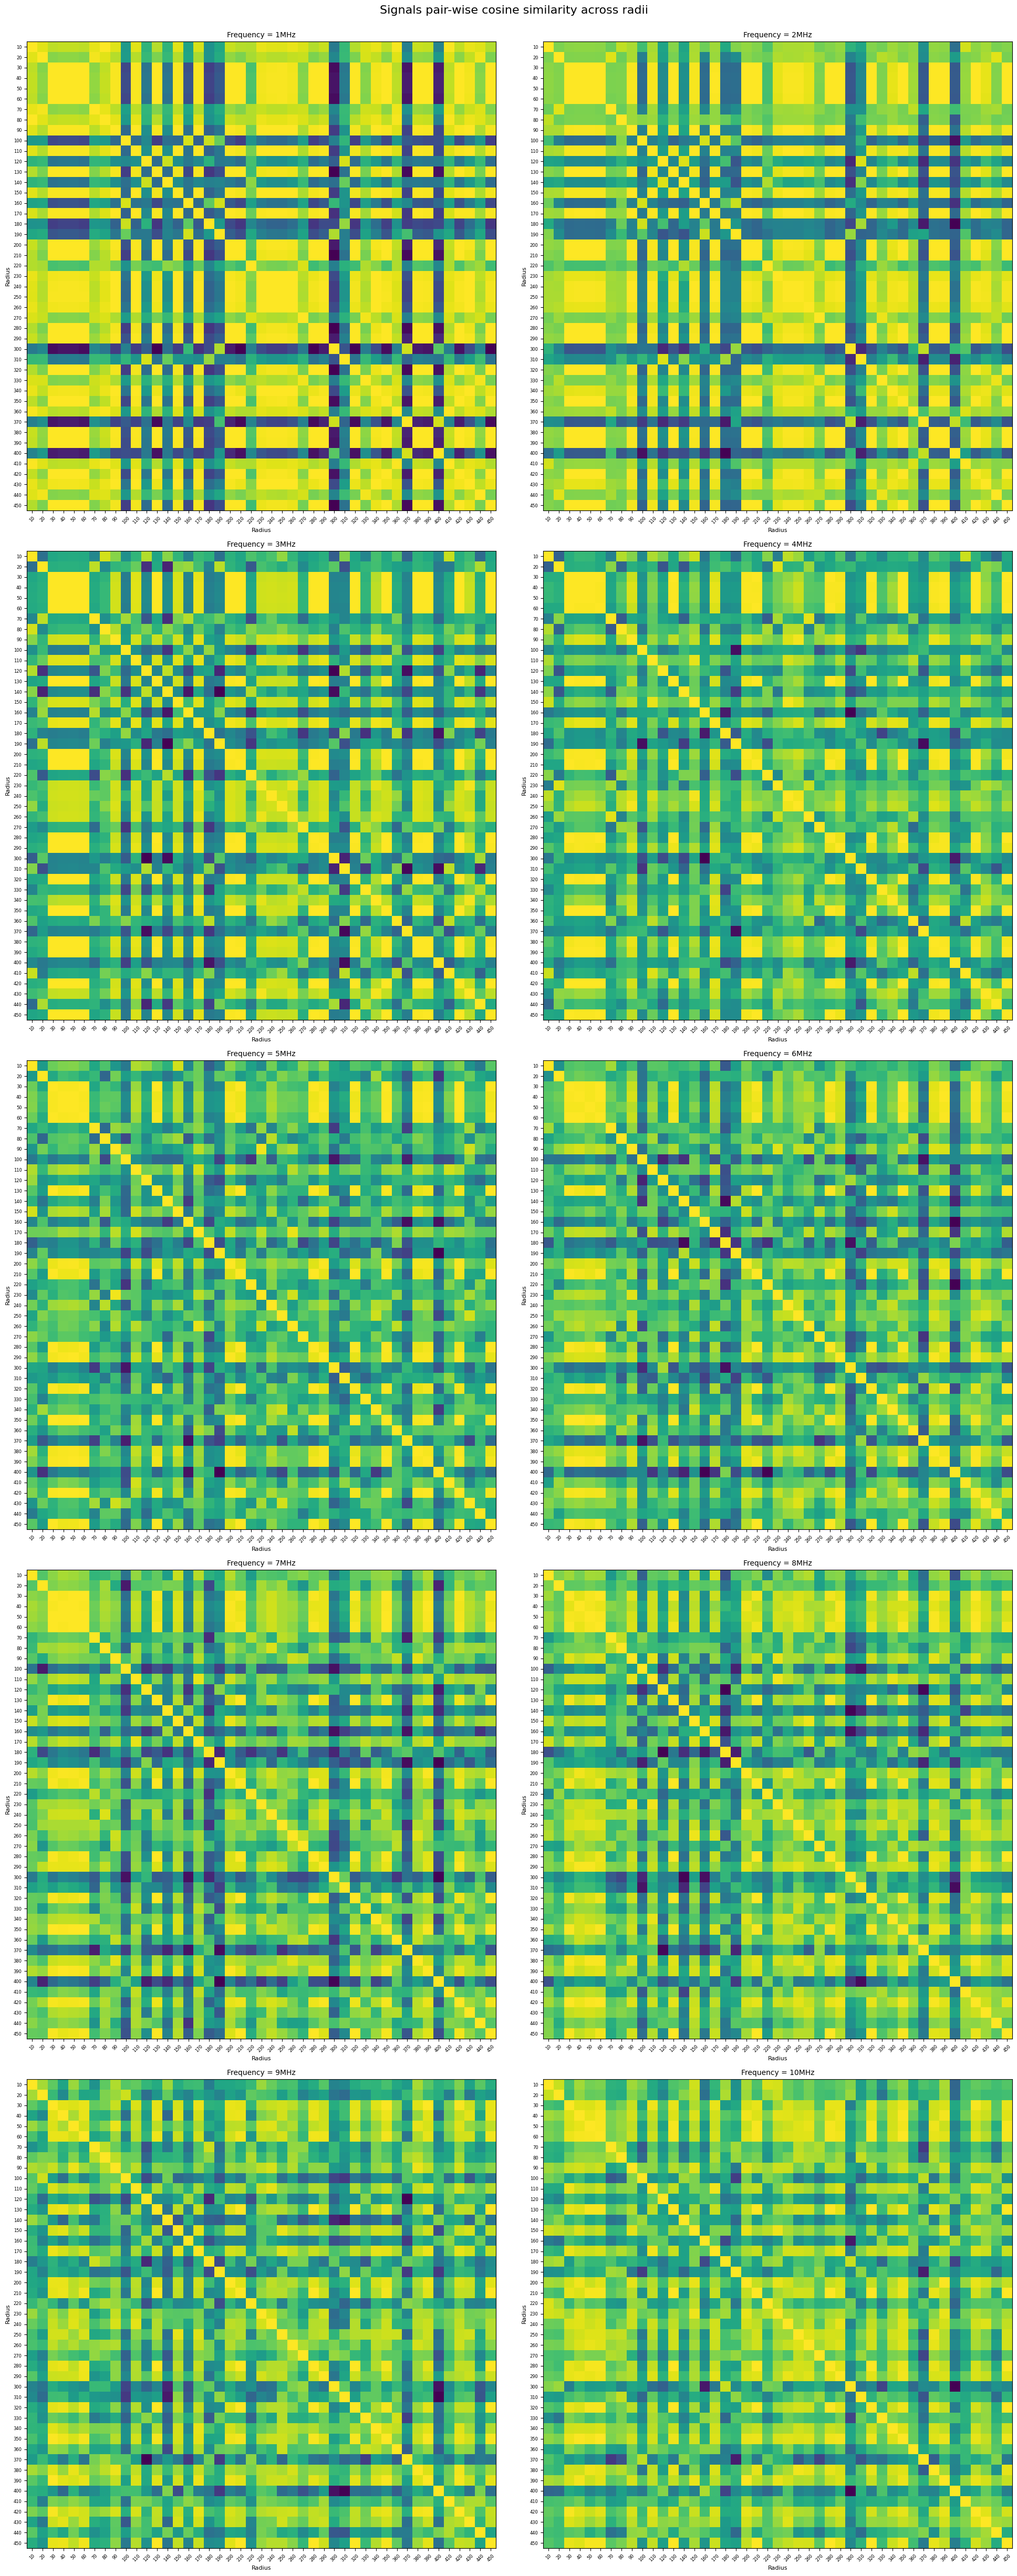

In [80]:
similarity_plot(embedding_type="none")

Let's compared these cross-similarity plots to that of a pseudo-random set of hypervectors.

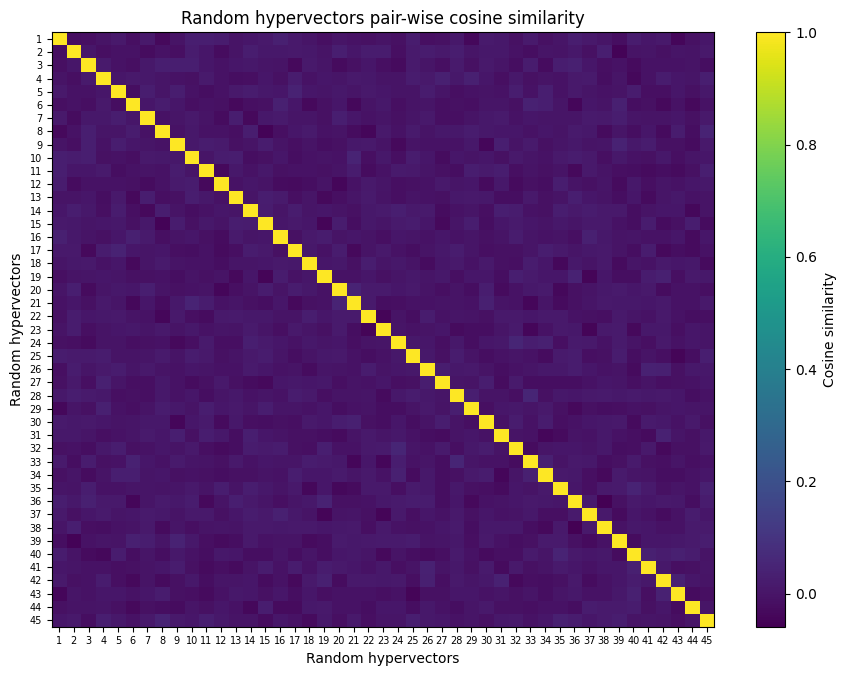

In [81]:
size = len(dataset.radius.values)
random_labels = size    
# Use the same format as for frequencies, i.e., a plot of 45x45 elements

# --- Compute similarity matrix ---
as_is_dataset = torchhd.HRRTensor(torch.randn(45,3480))
normed_as_is_dataset = F.normalize(as_is_dataset, p=2, dim=1)
similarity_matrix = normed_as_is_dataset @ normed_as_is_dataset.T
similarities_np = similarity_matrix.cpu().numpy()

# --- Plot ---
plt.figure(figsize=(9, 7))
plt.imshow(similarities_np, cmap="viridis", aspect="auto")
plt.colorbar(label="Cosine similarity")
plt.title("Random hypervectors pair-wise cosine similarity")
plt.xlabel("Random hypervectors")
plt.ylabel("Random hypervectors")
plt.xticks(ticks=(np.arange(size)), labels=(np.arange(size)+1), fontsize=7)
plt.yticks(ticks=(np.arange(size)), labels=(np.arange(size)+1), fontsize=7)

# --- Layout adjustments ---
# fig.suptitle("Signals pair-wise cosine similarity across radii", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

Comparing the cross-similarity plot grid of our dataset to the plot of a random set of hypervectors, it is pretty clear that our signals are definitly not pseudo-orthogonal. In fact, in many cases we can observe signals generated by different radius and central frequency parameters that are excruciantly similar. Bottomline: our signals denote an extremely noisy setting, and discriminating features in this space is all but straightforward. 

We can now verify whether embedding our signals helps to improve the signal-to-noise ratio. Let's try with a high similarity-preserving embedding like the sinusoidal one.

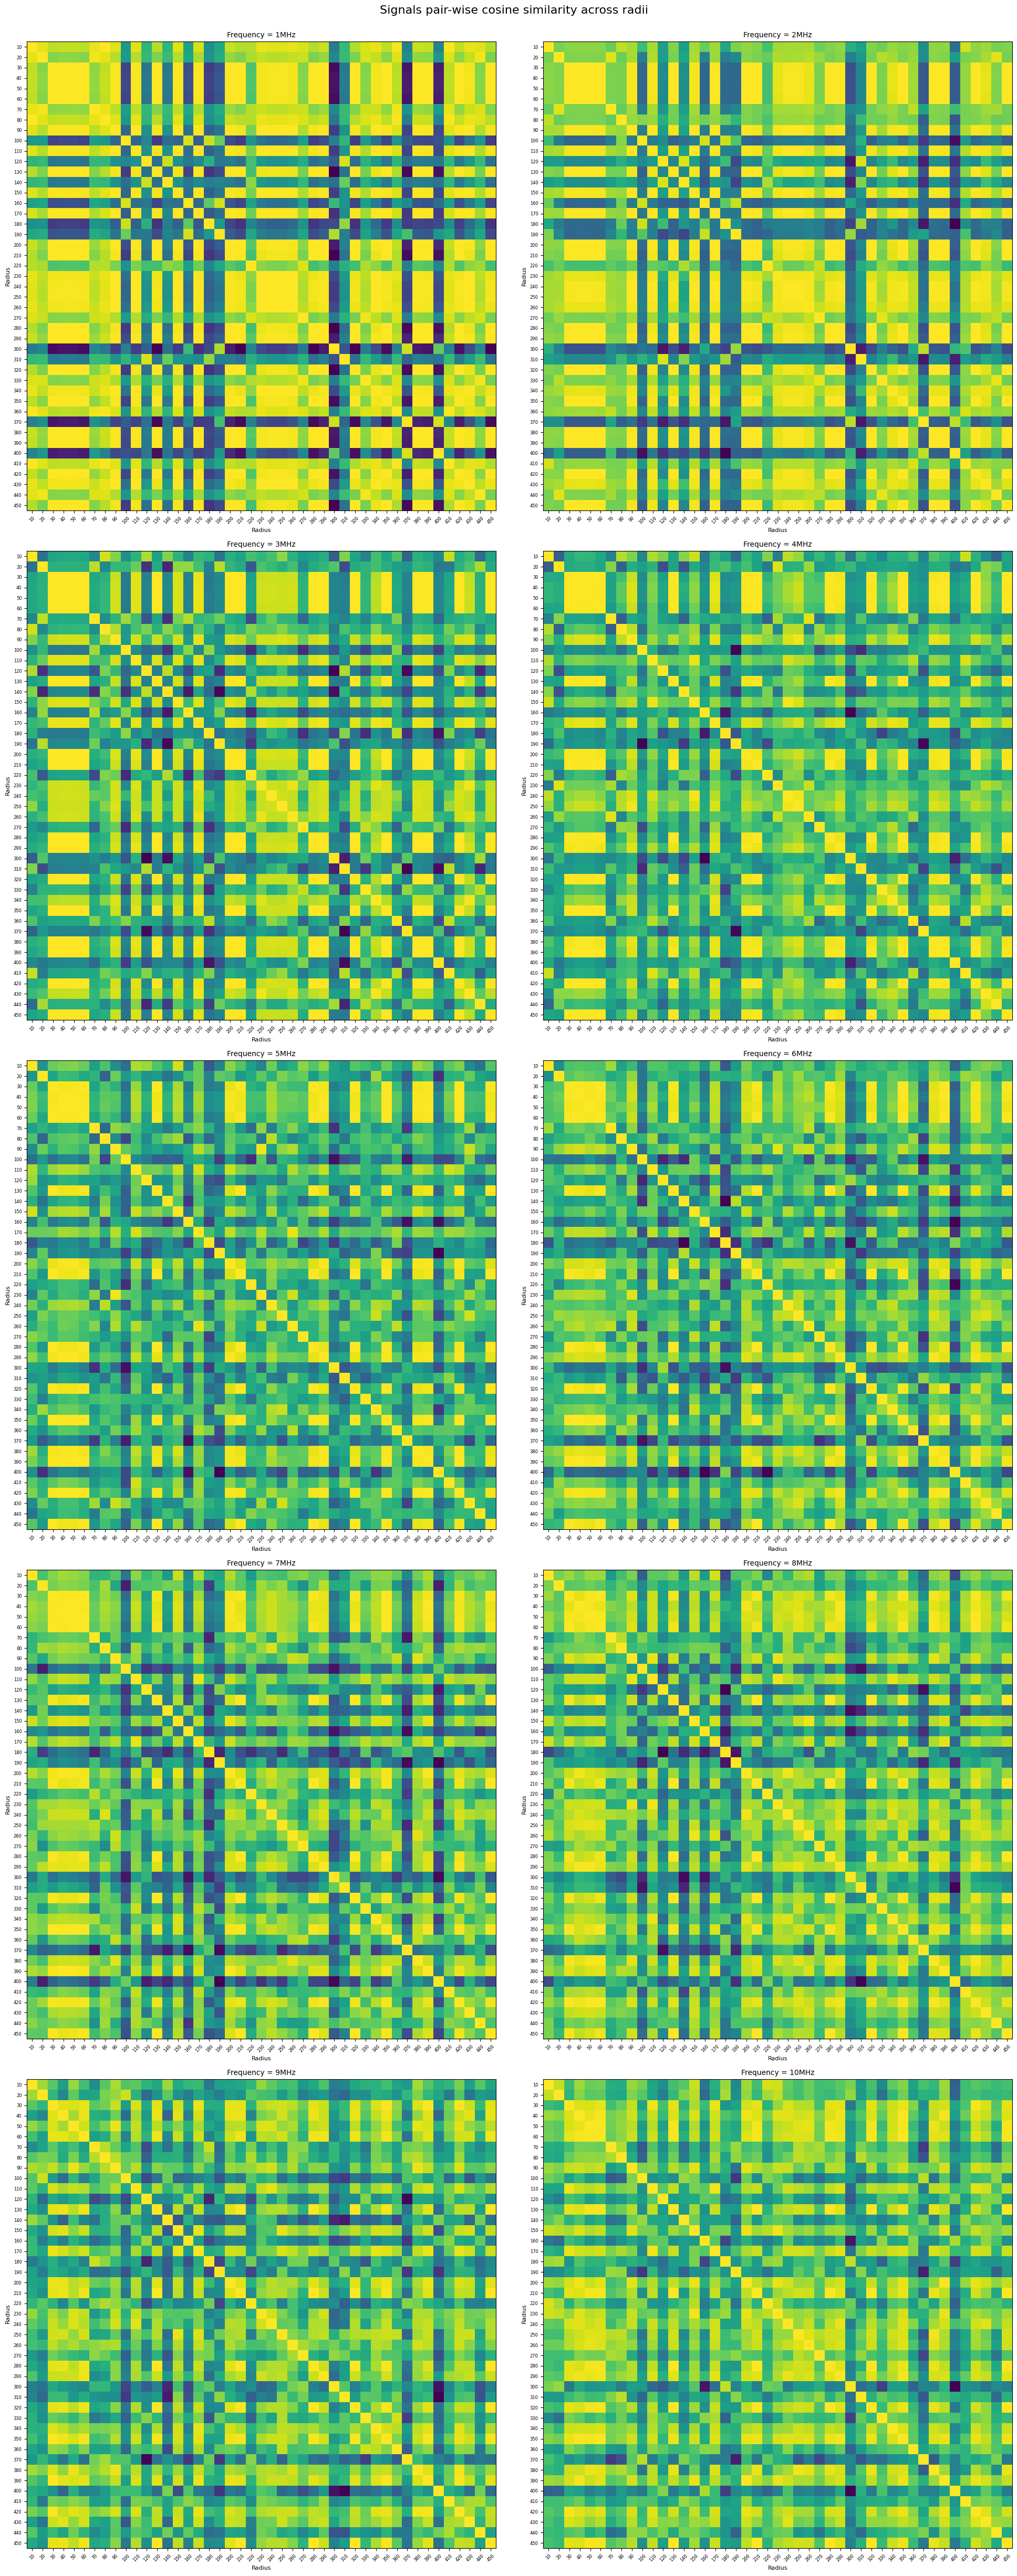

In [82]:
# embedding_type := {"none", "sinusoid", "projection", "fractional"}
similarity_plot(embedding_type="sinusoid")

Being the sinusoidal embedding heavily similary-preserving, the noise is not reduced by any visible margin. Still, we are left to quantify if it provides some statistically relevant benefit later on. For now, let's try with a less similarity-preserving embedding, like the "fractional" one.

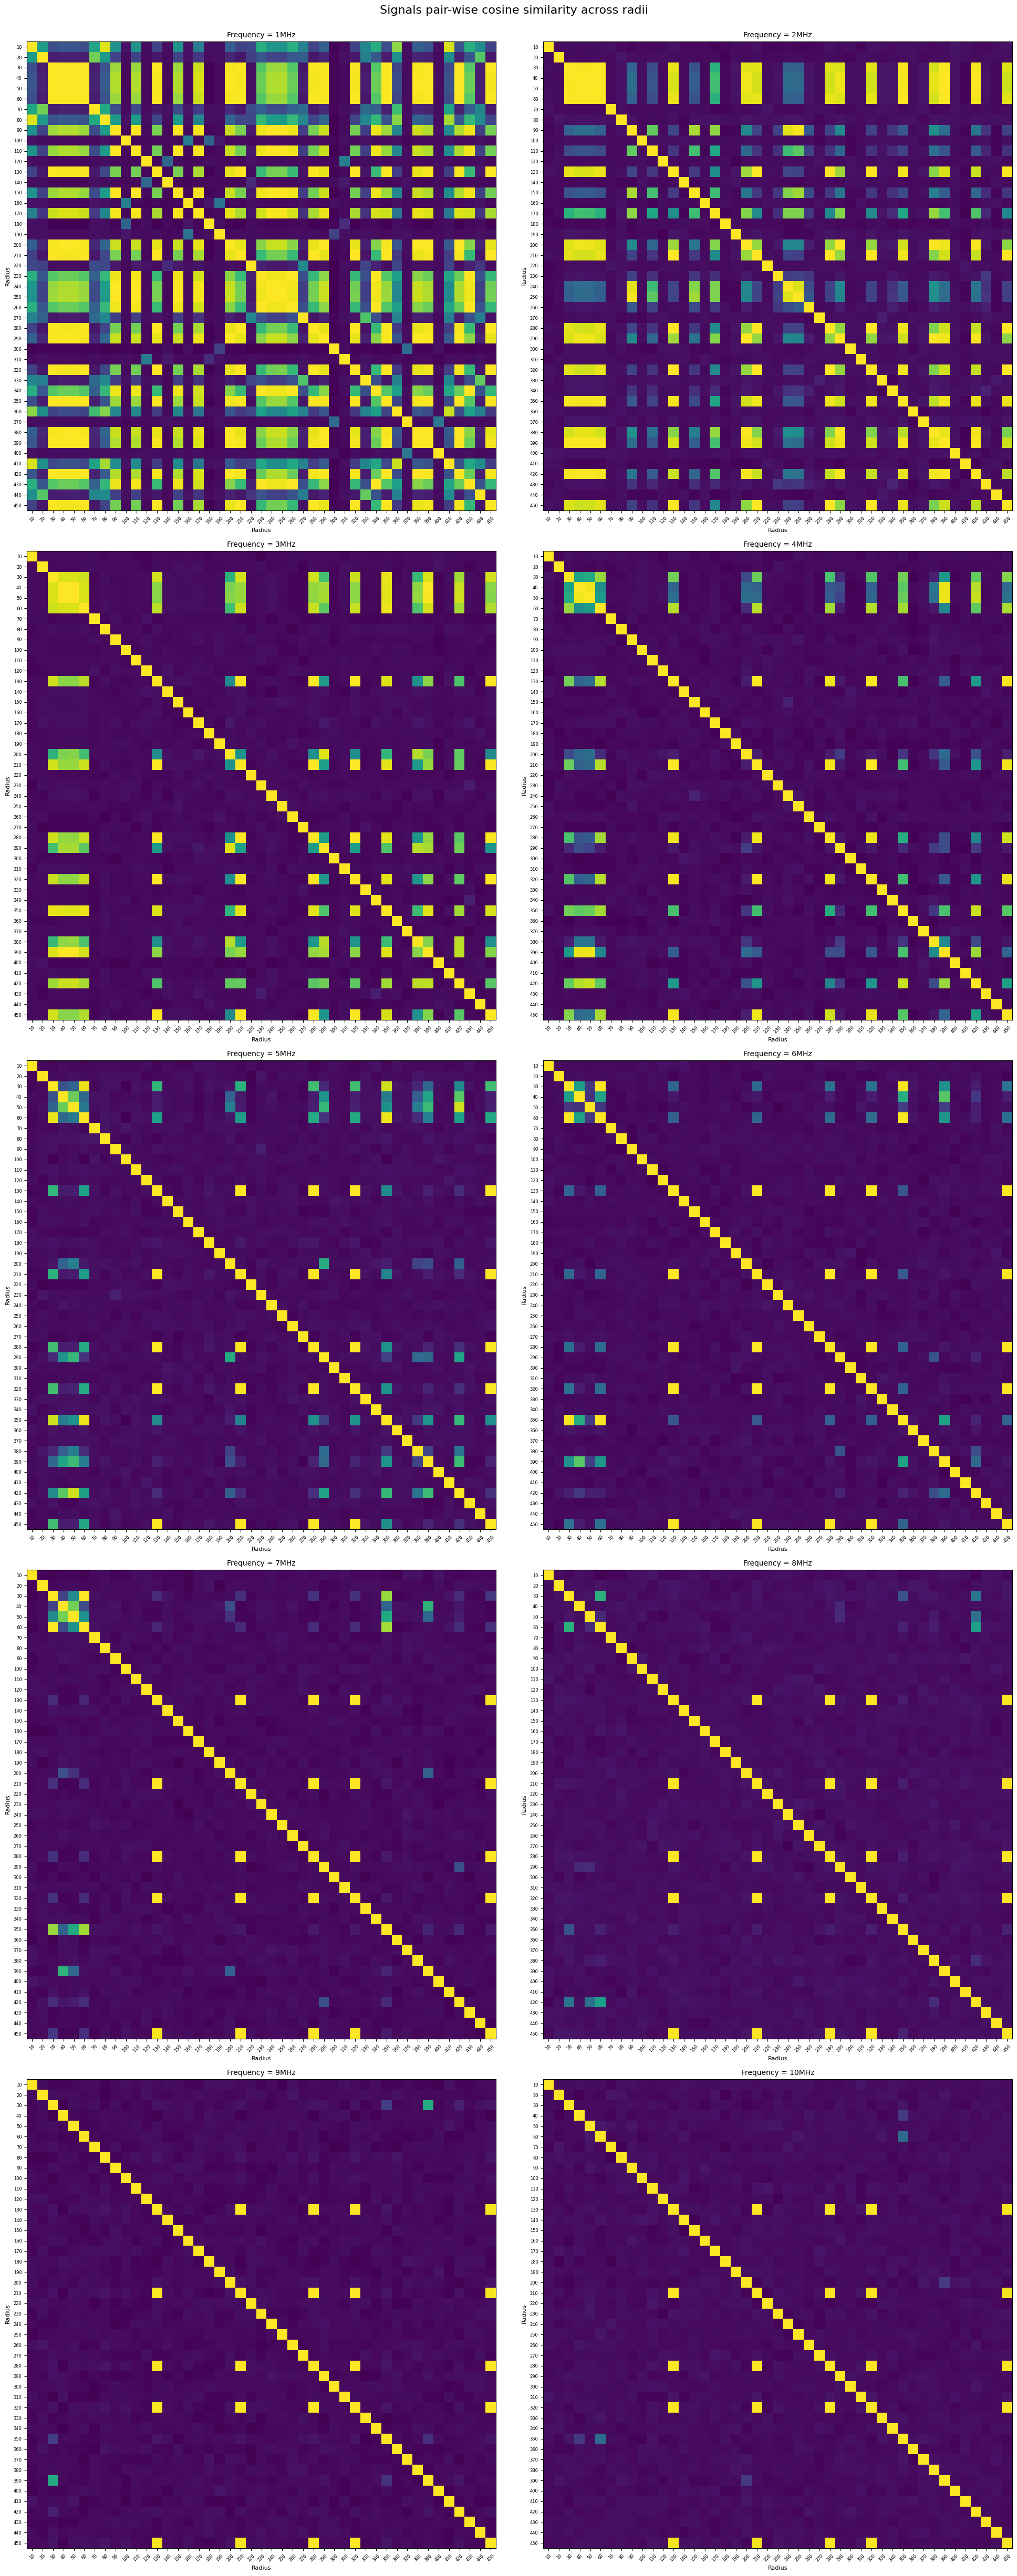

In [83]:
# embedding_type := {"none", "sinusoid", "projection", "fractional"}
similarity_plot(embedding_type="fractional")

The "fractional" embedding gives a picture much more similar to the cross-similarity plot of a set of pseudo-random hypervectors. The negative side, of course, is that we loose some similarity-preserving capability. 

A interesting venue can be opened: what if we superimpose a similarity-preserving embedding, like the sinusoidal, to a less-preserving one, like the fractional? For each signal, we can create a linear interpolation of these two embeddings, such that enough similarity-preservation is kept, and we can gain a little bit on the front of non-similarity/pseudo-orthogonality. We will not pursue embedding experiments here; we will explore them in the knowledge embedding notebook (kbe.ipynb).

A curious case emerges from the grid plot of the fractional embedding cross-similarity: signals reflected by acoustic traps of size 130, 210, 280, 320 are extremely similar independently from the central frequency they are conveyed.

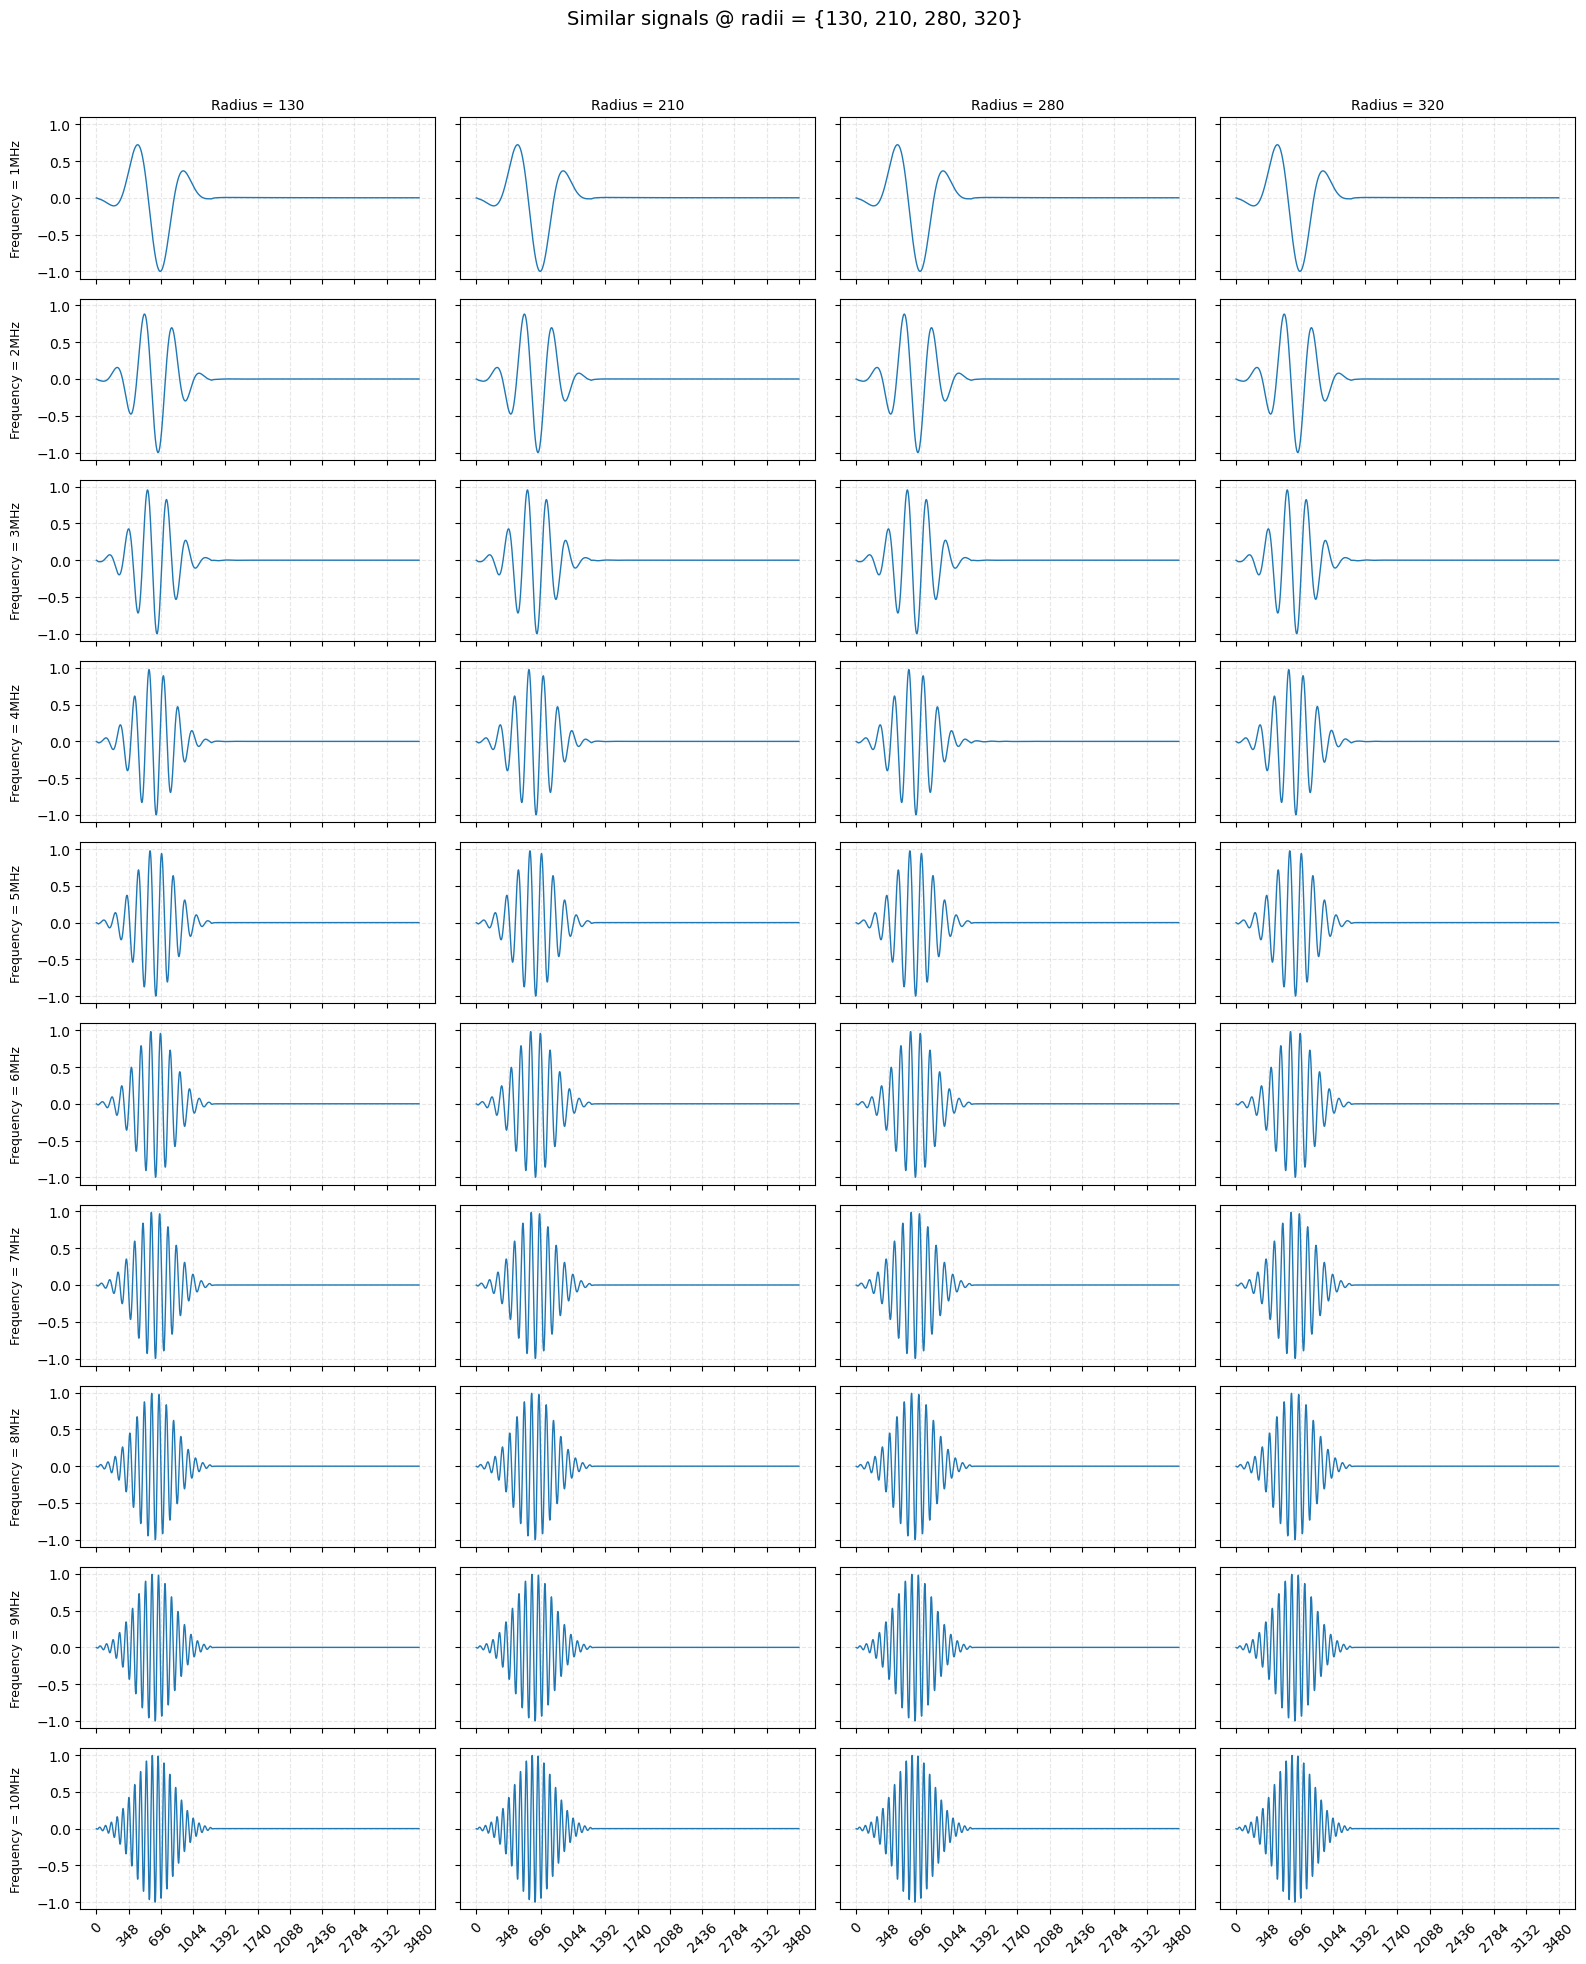

In [84]:
similar_signals = dataset.sel(radius=[130, 210, 280, 320])

fig, axes = plt.subplots(
    nrows=10, ncols=4,
    figsize=(16, 20),
    sharex=True, sharey=True
)

ax.grid(True, linestyle="--", alpha=0.3)
# Iterate over each frequency (row)
for i, f in enumerate(similar_signals.frequency.values):
    # Iterate over each radius (column)
    for j, r in enumerate(similar_signals.radius.values):
        ax = axes[i, j]

        # Extract the signal for this combination
        signal = similar_signals.sel(frequency=f, radius=r)

        # Plot across time dimension
        ax.plot(signal.time, signal, linewidth=1.0)
        ax.grid(True, linestyle="--", alpha=0.3)

        # Top row: column titles (radius)
        if i == 0:
            ax.set_title(f"Radius = {r}", fontsize=10)

        # Leftmost column: row labels (frequency)
        if j == 0:
            ax.set_ylabel(f"Frequency = {f}MHz", fontsize=9, rotation=90, labelpad=10)

        # Customization of the ticks and xticks labels
        ax.set_xticks(np.arange(0, signal.time.size + 1, 348))
        ax.set_yticks([-1, -0.5, 0, 0.5, 1])
        ax.set_xticklabels(np.arange(0, signal.time.size + 1, 348), fontsize=10, rotation=45)

# Overall title and layout
plt.suptitle("Similar signals @ radii = {130, 210, 280, 320}", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Confirming what we already so through the cross-similarity plots, the signals reflected at radii = {130, 210, 280, 320} conveyed at the same central frequency are essentially indistinguishable. Repeating the experiment using the unnormalized dataset (in the hope to harness a different amplitude of the signals themselves) does not change the situation. 